<img src="Firefly Mental Health in the Tech Industry. Big companies vs Remote work 97584.jpg" width="450" height="450">
<p style="font-family: San Francisco; font-size:2.75em;color:#0056D2; font-style:bold"> <br>Mental Health in the Tech Industry</p>
<br>

<a id="0"></a>
 ### [Table of Contents](0)
1. [Project Introduction](#1)      
1. [Preparation and Initial Inspection](#2)
    1. [Observations](#3) 
1. [Data Cleaning](#4) 
1. [Exploratory Analysis](#5)     
    1. [Glance to survey respondents](#6) 
    1. [Distribution of Ages and Engagement in Mental Health Disorder Treatment](#7)
    1. [Representation of Genders and Readiness to Address Mental Health](#8)
    1. [Geographical location and Level of mental health support](#9)
    1. [Mental Health perspectives. From Family History to Workplace Disclosures](#10)
    1. [Examining Mental Health Patterns in the Workplace: Remote Work, Employment Status, Company Size, Role, and Tech Industry Status](#11)
1. [Summary and Suggestions](#12)     
    
    

#### [Notebook by Mažvydas Brikas](https://www.linkedin.com/in/mazvydas-brikas/)      <br>[Turing College](https://www.turingcollege.com/)

<a id="1"></a> 
# 1. Project Introduction

The main objective of this project is to analyze Survey on Mental Health in the Tech Workplace in 2014, 2016, 2017, 2018, 2019. 
</p><br>Dataset Information:

This data is from Open Source Mental Illness (OSMI) using survey data from years 2014, 2016, 2017, 2018 and 2019. Each survey measures and attitudes towards mental health and frequency of mental health disorders in the tech workplace.

</p><br>Requirements:

- Load the data using SQLite and Pandas.
- Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, checking for correlations and other relations between variables, and other EDA elements.
- Provide clear explanations in your notebook. Your explanations should inform the reader what you are trying to achieve, what results did you get, and what these results mean.
- Provide suggestions about how your analysis can be improved.
 

</p><br>Objectives:

- Practice working with SQLite datasets.
- Practice performing EDA.
- Practice visualizing data with Matplotlib & Seaborn.
- Practice reading data, performing queries and filtering data using SQL and Pandas.
 
<br>

You can download dataset from [Kaggle](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry).

<a id="2"></a> 
# 2. Preparation and Initial Inspection

In [78]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import geopandas as gpd
from shapely.geometry import Point

# Connect to the SQLite database
conn = sqlite3.connect('mental_health.sqlite')

# Load data into Pandas DataFrames
survey_df = pd.read_sql_query("SELECT * FROM Survey;", conn)
question_df = pd.read_sql_query("SELECT * FROM Question;", conn)
answer_df = pd.read_sql_query("SELECT * FROM Answer;", conn)

# Set the default theme for Seaborn
sns.set_theme(context="notebook")

<a id="3"></a> 
## 2.1 Observations

In [8]:
# Display basic information about the datasets
print("Survey Data:")
print(survey_df.head())
print("\nQuestion Data:")
print(question_df.head())
print("\nAnswer Data:")
print(answer_df.head())

Survey Data:
   SurveyID                    Description
0      2014  mental health survey for 2014
1      2016  mental health survey for 2016
2      2017  mental health survey for 2017
3      2018  mental health survey for 2018
4      2019  mental health survey for 2019

Question Data:
                                        questiontext  questionid
0                                  What is your age?           1
1                               What is your gender?           2
2                       What country do you live in?           3
3  If you live in the United States, which state ...           4
4                             Are you self-employed?           5

Answer Data:
  AnswerText  SurveyID  UserID  QuestionID
0         37      2014       1           1
1         44      2014       2           1
2         32      2014       3           1
3         31      2014       4           1
4         31      2014       5           1


In [4]:
answer_df.describe

<bound method NDFrame.describe of                 AnswerText  SurveyID  UserID  QuestionID
0                       37      2014       1           1
1                       44      2014       2           1
2                       32      2014       3           1
3                       31      2014       4           1
4                       31      2014       5           1
...                    ...       ...     ...         ...
236893               Other      2016    2689         117
236894             Support      2016    2690         117
236895  Back-end Developer      2016    2691         117
236896     DevOps/SysAdmin      2016    2692         117
236897               Other      2016    2693         117

[236898 rows x 4 columns]>

<a id="4"></a> 
# 3. Data Cleaning
Missing value, duplicates and feature corrections.

In [90]:
answer_df.isna().sum()

AnswerText    0
SurveyID      0
UserID        0
QuestionID    0
dtype: int64

### Data quality 
* Quality varies between years survey was conducted.
* Some questions were added in later years and there is no data for previous years.
* Some answer contains -1 values. Keeping these values to see if relevant in different cases. 
* No missing values.

<a id="5"></a> 
# 4. Exploratory Analysis

<a id="6"></a> 
## 4.1 Glance to survey respondents

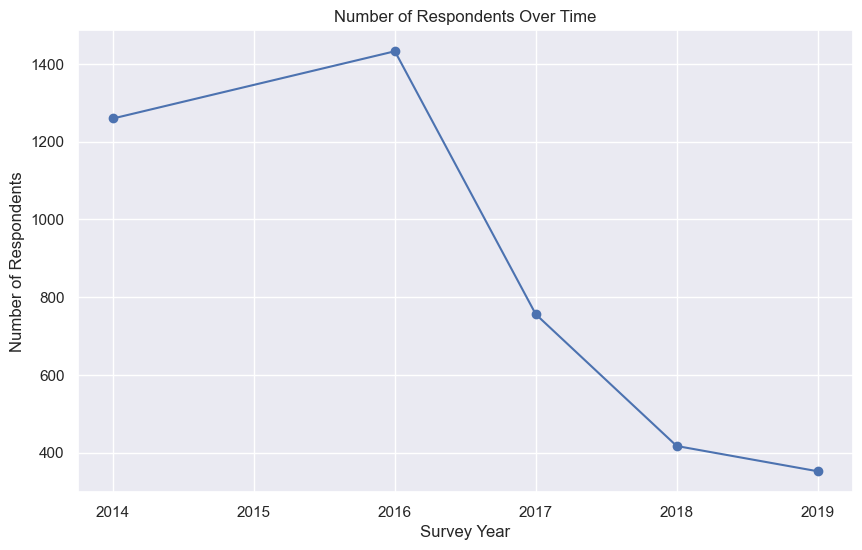

In [34]:
# Query to retrieve the number of respondents for each survey year
query = """
    SELECT SurveyID, COUNT(DISTINCT UserID) as NumRespondents
    FROM Answer
    GROUP BY SurveyID;
"""

respondents_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(10, 6))
plt.plot(respondents_data['SurveyID'], respondents_data['NumRespondents'], marker='o', linestyle='-')
plt.title('Number of Respondents Over Time')
plt.xlabel('Survey Year')
plt.ylabel('Number of Respondents')
plt.grid(True)
plt.show()

Examining survey participation trends to understand interest levels. The number of respondents increased from 2014 to 2016 but can see a subsequent decline in latter years.

<a id="7"></a> 
## 4.2 Distribution of Ages and Engagement in Mental Health Disorder Treatment

Now, we'll specifically explore the age distribution of employees surveyed between 2014 and 2019.

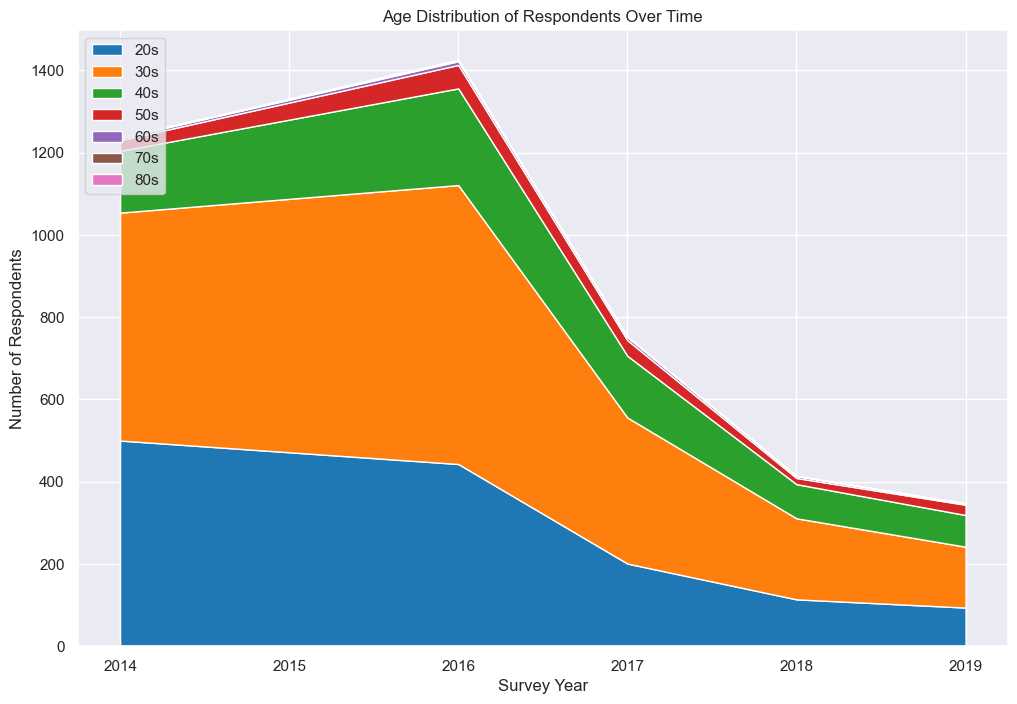

In [99]:
# Query to retrieve the age distribution for each survey year
query = """
    SELECT A.SurveyID,
           SUM(CASE WHEN CAST(A.AnswerText AS INTEGER) BETWEEN 20 AND 29 THEN 1 ELSE 0 END) as Age20s,
           SUM(CASE WHEN CAST(A.AnswerText AS INTEGER) BETWEEN 30 AND 39 THEN 1 ELSE 0 END) as Age30s,
           SUM(CASE WHEN CAST(A.AnswerText AS INTEGER) BETWEEN 40 AND 49 THEN 1 ELSE 0 END) as Age40s,
           SUM(CASE WHEN CAST(A.AnswerText AS INTEGER) BETWEEN 50 AND 59 THEN 1 ELSE 0 END) as Age50s,
           SUM(CASE WHEN CAST(A.AnswerText AS INTEGER) BETWEEN 60 AND 69 THEN 1 ELSE 0 END) as Age60s,
           SUM(CASE WHEN CAST(A.AnswerText AS INTEGER) BETWEEN 70 AND 79 THEN 1 ELSE 0 END) as Age70s,
           SUM(CASE WHEN CAST(A.AnswerText AS INTEGER) >= 80 THEN 1 ELSE 0 END) as Age80s
    FROM Answer A
    JOIN Question Q ON A.QuestionID = Q.QuestionID
    WHERE Q.QuestionText = 'What is your age?'
    GROUP BY A.SurveyID;
"""

age_distribution_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(12, 8))
plt.stackplot(age_distribution_data['SurveyID'],
              age_distribution_data['Age20s'],
              age_distribution_data['Age30s'],
              age_distribution_data['Age40s'],
              age_distribution_data['Age50s'],
              age_distribution_data['Age60s'],
              age_distribution_data['Age70s'],
              age_distribution_data['Age80s'],
              labels=['20s', '30s', '40s', '50s', '60s', '70s', '80s'],
              colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
plt.title('Age Distribution of Respondents Over Time')
plt.xlabel('Survey Year')
plt.ylabel('Number of Respondents')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Most of respondents are in younger groups 20s and 30s.
Seems that average age shifted to 30s group moving from 2014 to 2016.

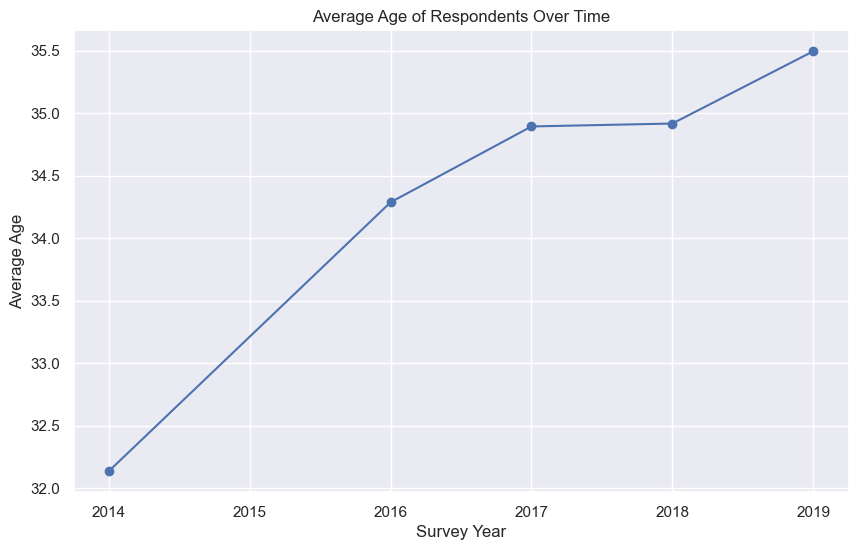

In [36]:
# Query to retrieve the age of respondents for each survey year
query = """
    SELECT A.SurveyID, AVG(CAST(A.AnswerText AS INTEGER)) as AvgAge
    FROM Answer A
    JOIN Question Q ON A.QuestionID = Q.QuestionID
    WHERE Q.QuestionText = 'What is your age?'
    GROUP BY A.SurveyID;
"""

age_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(10, 6))
plt.plot(age_data['SurveyID'], age_data['AvgAge'], marker='o', linestyle='-')
plt.title('Average Age of Respondents Over Time')
plt.xlabel('Survey Year')
plt.ylabel('Average Age')
plt.grid(True)
plt.show()

Indeed moving throughout the years Average age of respondents moving up.

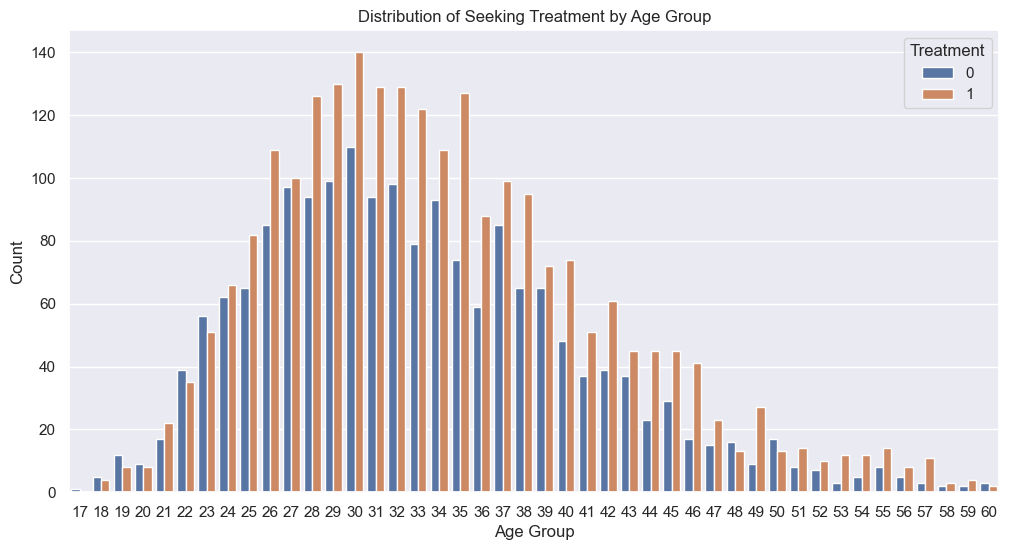

In [95]:
# "What is your age?" is 1 and for "Have you ever sought treatment for a mental health disorder from a mental health professional?" is 7

valid_age_range = (16, 60)

# Query to get the overall relationship between age and seeking treatment
query = f"""
    SELECT Age.AnswerText as AgeGroup, Treatment.AnswerText as Treatment, COUNT(*) as Count
    FROM Answer as Age
    JOIN Answer as Treatment ON Age.UserID = Treatment.UserID
    WHERE Age.QuestionID = 1 AND Treatment.QuestionID = 7
    AND CAST(Age.AnswerText AS INTEGER) BETWEEN {valid_age_range[0]} AND {valid_age_range[1]}
    GROUP BY Age.AnswerText, Treatment.AnswerText;
"""

age_treatment_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(12, 6))
sns.barplot(x='AgeGroup', y='Count', hue='Treatment', data=age_treatment_data)
plt.title('Distribution of Seeking Treatment by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

### It appears that individuals in the younger age groups, specifically those aged 17-27, are less inclined to seek treatment for mental health disorders from professionals. The propensity to seek treatment notably increases among individuals aged 28 and older.

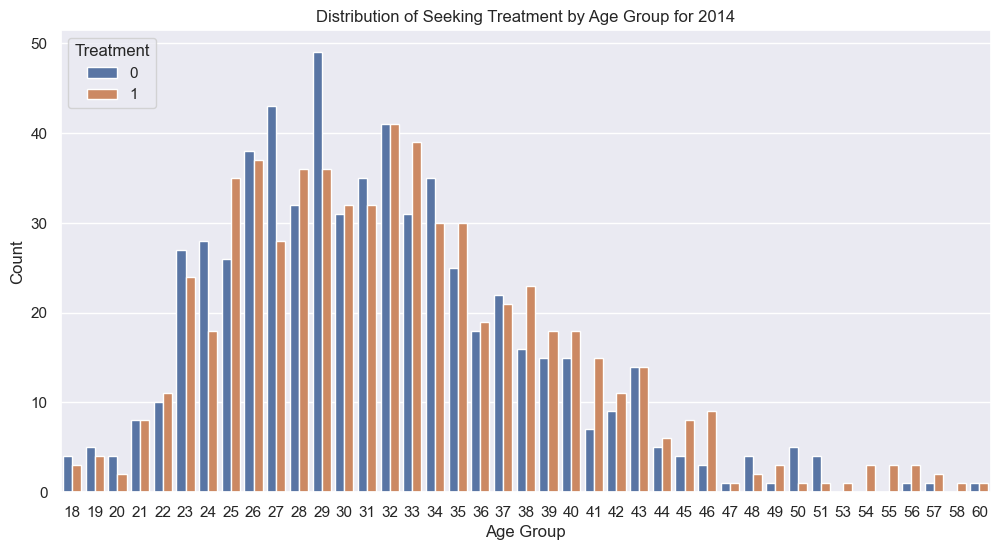

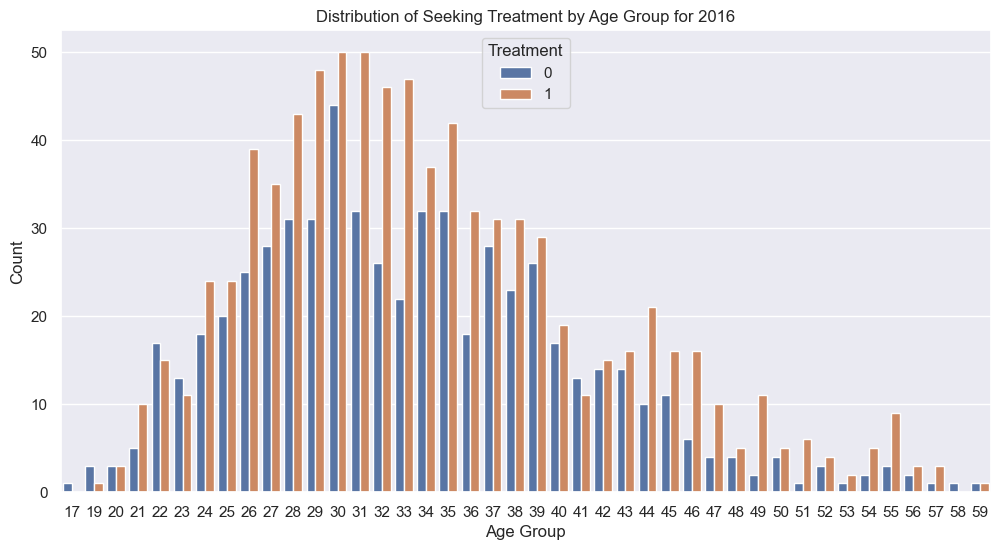

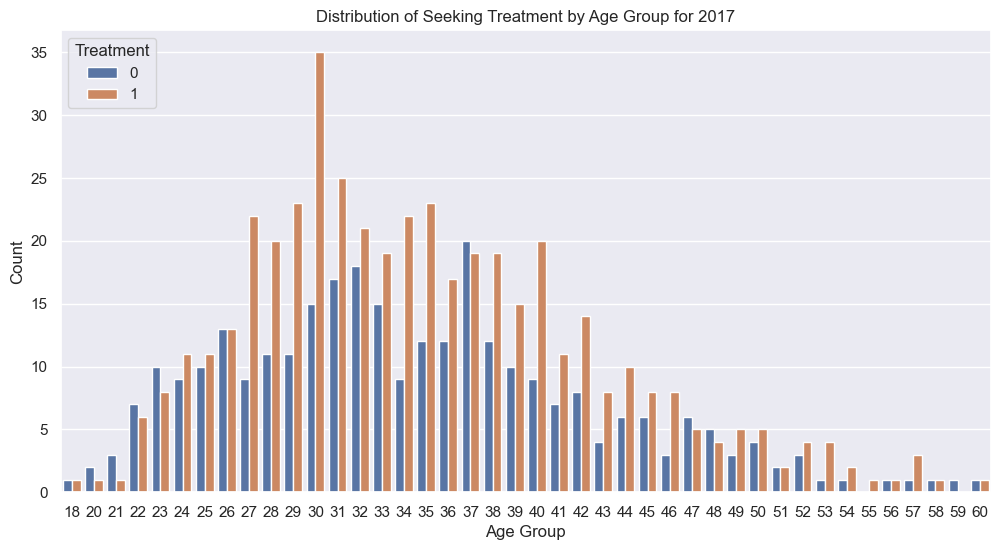

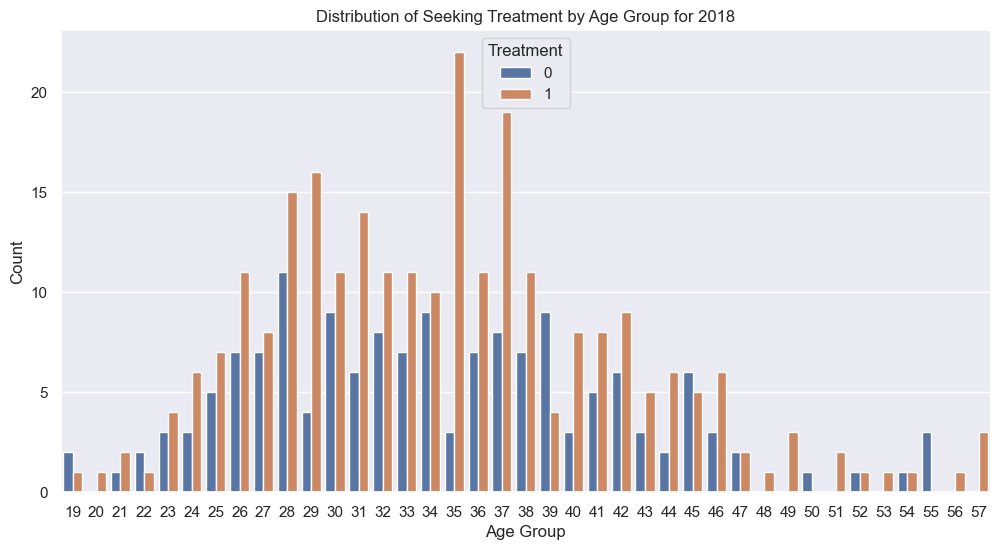

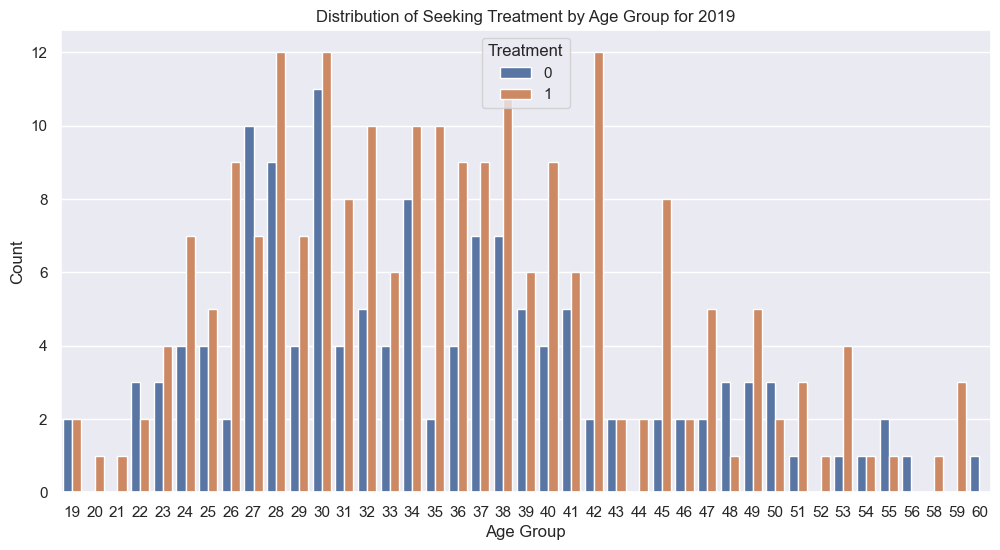

In [96]:
valid_age_range = (16, 60)

for survey_year in [2014, 2016, 2017, 2018, 2019]:
    query = f"""
        SELECT Age.AnswerText as AgeGroup, Treatment.AnswerText as Treatment, COUNT(*) as Count
        FROM Answer as Age
        JOIN Answer as Treatment ON Age.UserID = Treatment.UserID
        WHERE Age.QuestionID = 1 AND Treatment.QuestionID = 7
        AND Age.SurveyID = {survey_year}
        AND CAST(Age.AnswerText AS INTEGER) BETWEEN {valid_age_range[0]} AND {valid_age_range[1]}
        GROUP BY Age.AnswerText, Treatment.AnswerText;
    """

    age_treatment_data = pd.read_sql_query(query, conn)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='AgeGroup', y='Count', hue='Treatment', data=age_treatment_data)
    plt.title(f'Distribution of Seeking Treatment by Age Group for {survey_year}')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.show()

It appears that there is a growing interest in seeking treatment for mental health disorders over the years. The initial survey in 2014 indicated significantly lower interest compared to subsequent years.

 <a id="8"></a> 
## 4.3 Representation of Genders and Readiness to Address Mental Health

In [91]:
# "What is your gender?" is 2

# Query to get the top 20 genders based on count in descending order
query = """
    SELECT AnswerText as Gender, COUNT(*) as Count
    FROM Answer
    WHERE QuestionID = 2
    GROUP BY AnswerText
    ORDER BY Count DESC
    LIMIT 10;
"""

top_genders_data = pd.read_sql_query(query, conn)
top_genders_data

,Gender,Count
0,Male,2830
1,Female,914
2,male,212
3,female,110
4,-1,24
5,Nonbinary,8
6,non-binary,6
7,Genderqueer,4
8,Agender,4
9,None,3


### It appears that the survey is predominantly composed of male respondents.

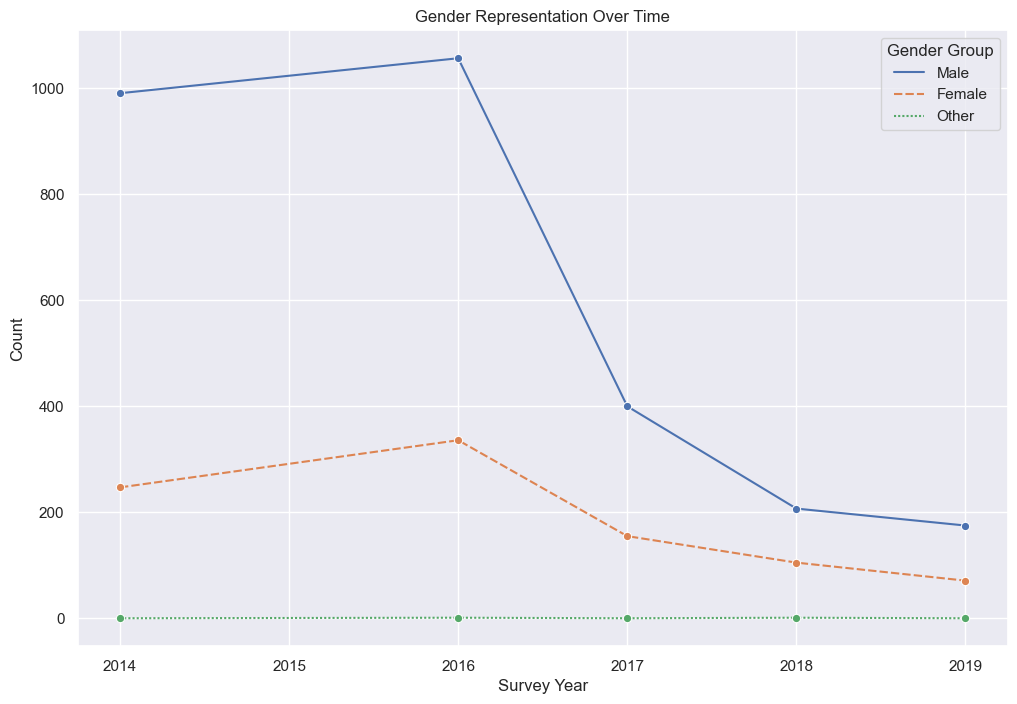

In [39]:
#"What is your gender?" is 2

gender_mapping = {
    'Male': 'Male',
    'Female': 'Female',
    # other genders grouped into 'Other'
}

# Query to get the gender representation over the years
query = f"""
    SELECT Survey.SurveyID, Survey.Description, Gender.AnswerText as GenderGroup, COUNT(*) as Count
    FROM Answer as Gender
    JOIN Survey ON Gender.SurveyID = Survey.SurveyID
    WHERE Gender.QuestionID = 2
    AND Gender.AnswerText IN ('Male', 'Female', 'Other')
    GROUP BY Survey.SurveyID, Gender.AnswerText;
"""

gender_representation_data = pd.read_sql_query(query, conn)

gender_representation_pivot = gender_representation_data.pivot(index='SurveyID', columns='GenderGroup', values='Count').fillna(0)

plt.figure(figsize=(12, 8))
sns.lineplot(data=gender_representation_pivot[['Male', 'Female', 'Other']], marker='o')
plt.title('Gender Representation Over Time')
plt.xlabel('Survey Year')
plt.ylabel('Count')
plt.legend(title='Gender Group')
plt.show()

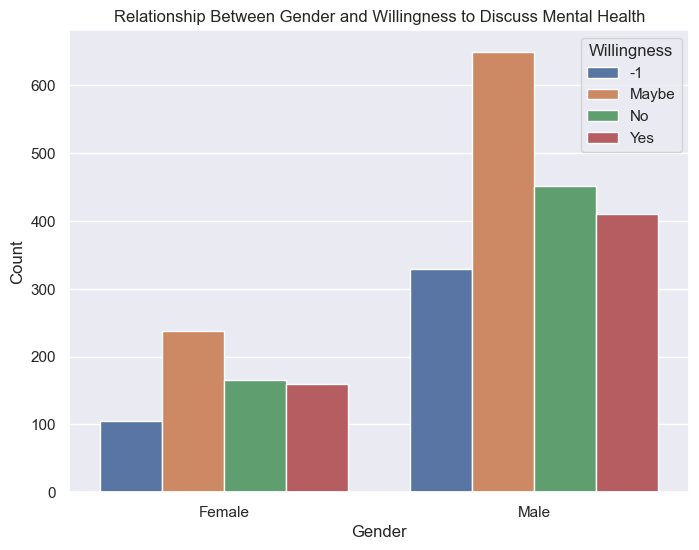

In [97]:
# "What is your gender?" is 2 and for "Would you feel comfortable discussing a mental health issue with your coworkers?" is 18

# Query to get the relationship between gender and willingness to discuss mental health
query = """
    SELECT Gender.AnswerText as Gender, Discussion.AnswerText as Willingness, COUNT(*) as Count
    FROM Answer as Gender
    JOIN Answer as Discussion ON Gender.UserID = Discussion.UserID
    WHERE Gender.QuestionID = 2 AND Discussion.QuestionID = 18
    AND (Gender.AnswerText = 'Male' OR Gender.AnswerText = 'Female')  -- Considering only male and female
    GROUP BY Gender.AnswerText, Discussion.AnswerText;
"""

gender_discussion_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(8, 6))
sns.barplot(x='Gender', y='Count', hue='Willingness', data=gender_discussion_data)
plt.title('Relationship Between Gender and Willingness to Discuss Mental Health')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### It appears that there is a similar willingness among both males and females to discuss mental health.

<a id="9"></a> 
## 4.4 Geographical location and Level of mental health support

/var/folders/3f/y_m2swbd2g7cvkrl95_20q_80000gn/T/ipykernel_6810/3120199521.py:18: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


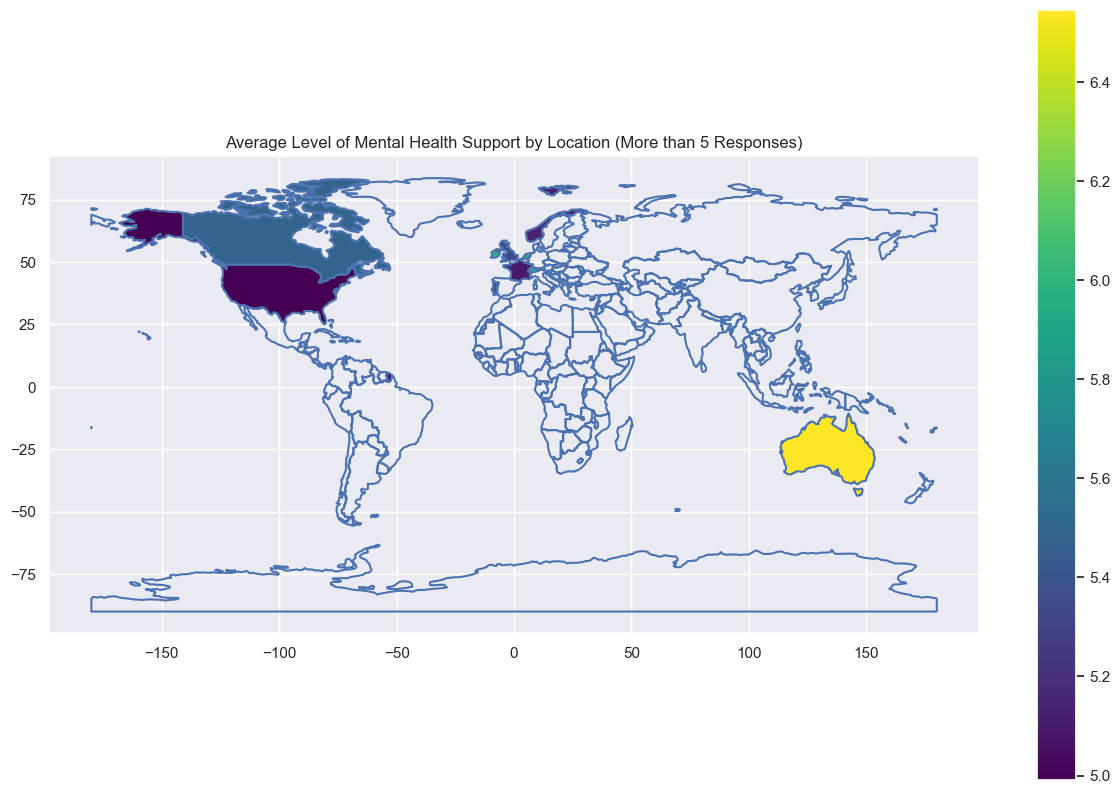

In [44]:
# "Geographical location" is 3 and for "Level of mental health support" is 65
geographical_query = """
    SELECT Geography.AnswerText as Location, AVG(CAST(Support.AnswerText AS REAL)) as SupportLevel, COUNT(*) as ResponseCount
    FROM Answer as Geography
    JOIN Answer as Support ON Geography.UserID = Support.UserID
    WHERE Geography.QuestionID = 3
        AND Support.QuestionID = 65
        AND CAST(Support.AnswerText AS REAL) >= 0
    GROUP BY Geography.AnswerText
    HAVING COUNT(*) > 5
    ORDER BY SupportLevel DESC
    LIMIT 10;
"""

geographical_data = pd.read_sql_query(geographical_query, conn)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
all_countries = gpd.GeoDataFrame(world['geometry'])
all_countries = all_countries.merge(geographical_data, left_on=world['name'], right_on='Location', how='left')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
all_countries.boundary.plot(ax=ax)
all_countries[~all_countries['SupportLevel'].isnull()].plot(column='SupportLevel', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Average Level of Mental Health Support by Location (More than 5 Responses)')
plt.show()

In [78]:
top_countries_table = geographical_data[['Location', 'SupportLevel', 'ResponseCount']].copy()
top_countries_table['Rank'] = range(1, 11)
top_countries_table.set_index('Rank', inplace=True)
top_countries_table.columns = ['Country', 'Average Support Level', 'Response Count']
top_countries_table

,Country,Average Support Level,Response Count
Rank,,,
1,Australia,6.545455,11
2,Switzerland,6.000000,10
3,Netherlands,6.000000,15
4,Ireland,6.000000,7
5,Canada,5.484848,33
6,Portugal,5.368421,19
7,United Kingdom,5.333333,93
8,Norway,5.142857,7
9,France,5.100000,20


### It appears that a majority of respondents are based in the United States. Let's examine the Average Support Levels by State.

In [47]:
# "State" is 4 and for "Level of mental health support" is 65
# Query to get the relationship between state and mental health support
state_query = """
    SELECT State.AnswerText as State, 
        AVG(CAST(Support.AnswerText AS REAL)) as SupportLevel,
        COUNT(*) as ResponseCount
    FROM Answer as State
    JOIN Answer as Support ON State.UserID = Support.UserID
    WHERE State.QuestionID = 4
        AND Support.QuestionID = 65
        AND CAST(Support.AnswerText AS REAL) >= 0
        AND State.AnswerText != -1  -- Exclude states with value -1
    GROUP BY State.AnswerText
    HAVING ResponseCount > 25
    ORDER BY SupportLevel DESC  -- Sort in descending order
    LIMIT 10;
"""

state_data = pd.read_sql_query(state_query, conn)
state_data = state_data.sort_values(by='SupportLevel')


sorted_table = state_data[['State', 'ResponseCount', 'SupportLevel']].reset_index(drop=True)
sorted_table

,State,ResponseCount,SupportLevel
0,Washington,54,4.500000
1,Pennsylvania,28,4.714286
2,California,101,4.881188
3,Oregon,29,5.275862
4,Indiana,40,5.375000
5,Texas,28,5.392857
6,Massachusetts,33,5.515152
7,Illinois,122,5.713115
8,New York,40,5.775000
9,Michigan,36,6.166667


### Michigan, New York, and Illinois emerge as frontrunners in providing mental health support.

<a id="10"></a> 
## 4.5 Mental Health perspectives. From Family History to Workplace Disclosures

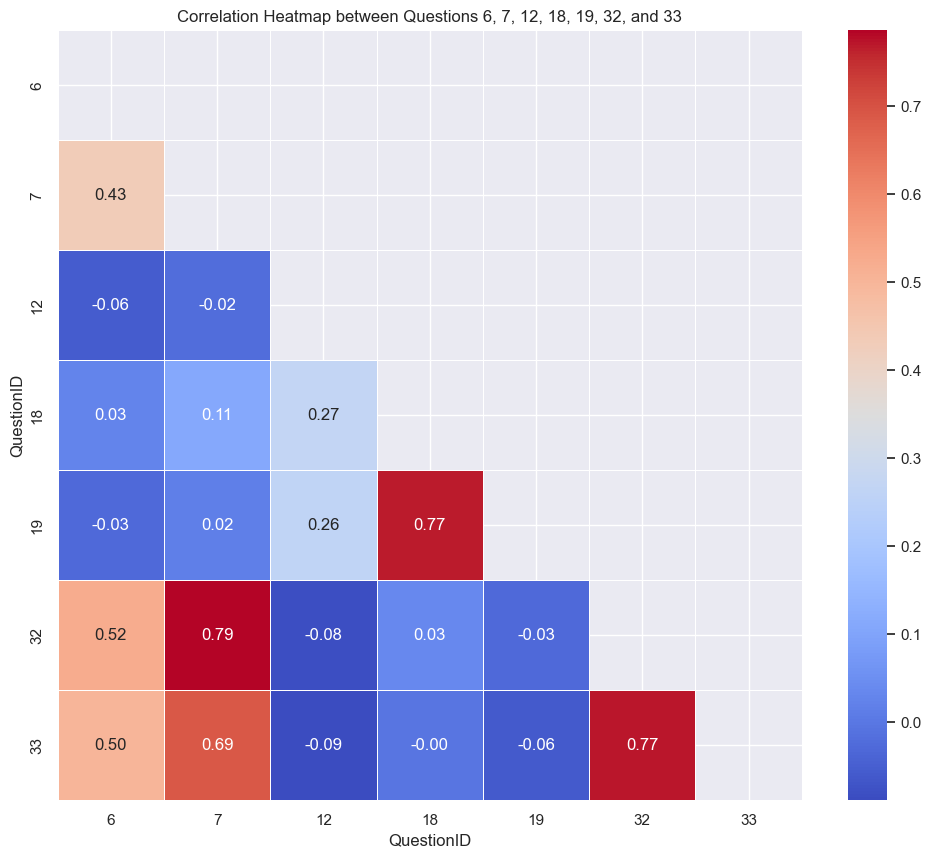

In [52]:
def preprocess_binary_answers(answer_text):
    # Convert 'Yes' to 1, 'No' to 0, and exclude other values
    if answer_text == 'Yes' or answer_text == '1':
        return 1
    elif answer_text == 'No' or answer_text == '0':
        return 0
    else:
        return None

# Connect to the SQLite database
conn = sqlite3.connect('mental_health.sqlite')

# Query to retrieve data for the correlation matrix
query = """
    SELECT A.UserID,
           A.SurveyID,
           A.QuestionID,
           A.AnswerText
    FROM Answer A
    JOIN Question Q ON A.QuestionID = Q.QuestionID
    WHERE Q.QuestionID IN (6, 7, 12, 18, 19, 32, 33)
    AND A.AnswerText NOT IN ("I don't know", 'Maybe', 'Other');
"""

correlation_data = pd.read_sql_query(query, conn)

correlation_data['Answer'] = correlation_data['AnswerText'].apply(preprocess_binary_answers)

correlation_matrix_data = correlation_data.pivot_table(index='UserID', columns='QuestionID', values='Answer', aggfunc='first')

correlation_matrix = correlation_matrix_data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, mask=mask)
plt.title('Correlation Heatmap between Questions 6, 7, 12, 18, 19, 32, and 33')
plt.show()

Questions:<br>
6 - Do you have a family history of mental illness?  <br>
7 - Have you ever sought treatment for a mental health disorder from a mental health professional? <br>
12 - Would you bring up a mental health issue with a potential employer in an interview? <br>
18 - Would you feel comfortable discussing a mental health issue with your coworkers? <br>
19 - Would you feel comfortable discussing a mental health issue with your direct supervisor(s)? <br>
32 - Have you had a mental health disorder in the past? <br>
33 - Do you currently have a mental health disorder? <br>

* Strong link: past mental health disorder and current condition.
* Strong correlation between family mental health history and past/present disorders.
* Strong correlation between seeking treatment and past and present mental health issues.
* Strong correlation between feeling comfortable discussing mental health issues with coworkers and feeling comfortable discussing them with direct supervisors.

<a id="11"></a> 
## 4.6 Examining Mental Health Patterns in the Workplace: Remote Work, Employment Status, Company Size, Role, and Tech Industry Status

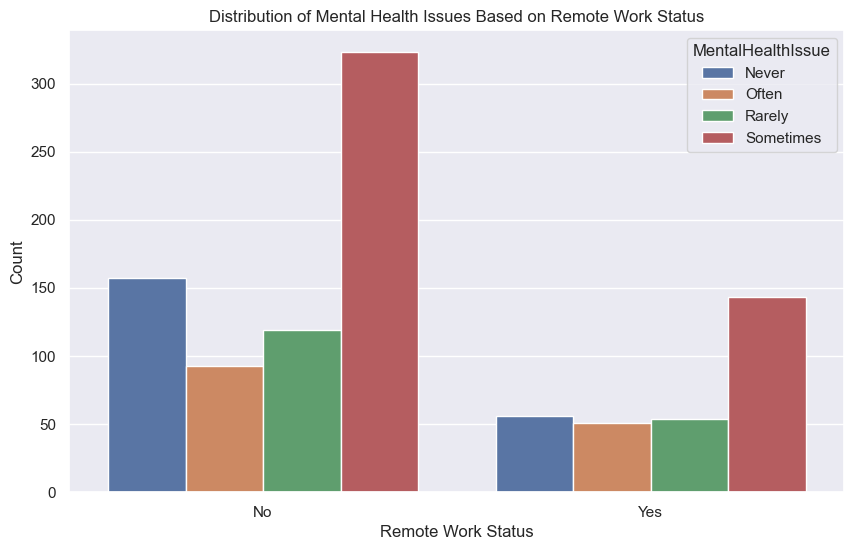

In [73]:
remote_work_question_id = 93  # "Do you work remotely (outside of an office) at least 50% of the time?"
mental_health_issue_question_id = 92  # "If you have a mental health condition, do you feel that it interferes with your work?"

# Query to retrieve data for the analysis, excluding -1 values for question 92
query = f"""
    SELECT RemoteWork.AnswerText as RemoteWorkStatus, MentalHealth.AnswerText as MentalHealthIssue, COUNT(*) as Count
    FROM Answer as RemoteWork
    JOIN Answer as MentalHealth ON RemoteWork.UserID = MentalHealth.UserID
    WHERE RemoteWork.QuestionID = {remote_work_question_id} 
        AND MentalHealth.QuestionID = {mental_health_issue_question_id}
        AND MentalHealth.AnswerText != '-1'
    GROUP BY RemoteWork.AnswerText, MentalHealth.AnswerText;
"""

remote_vs_office_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(10, 6))
sns.barplot(x='RemoteWorkStatus', y='Count', hue='MentalHealthIssue', data=remote_vs_office_data)
plt.title('Distribution of Mental Health Issues Based on Remote Work Status')
plt.xlabel('Remote Work Status')
plt.ylabel('Count')
plt.show()

### It appears that individuals who work remotely experience a lesser impact on their work due to mental health conditions.

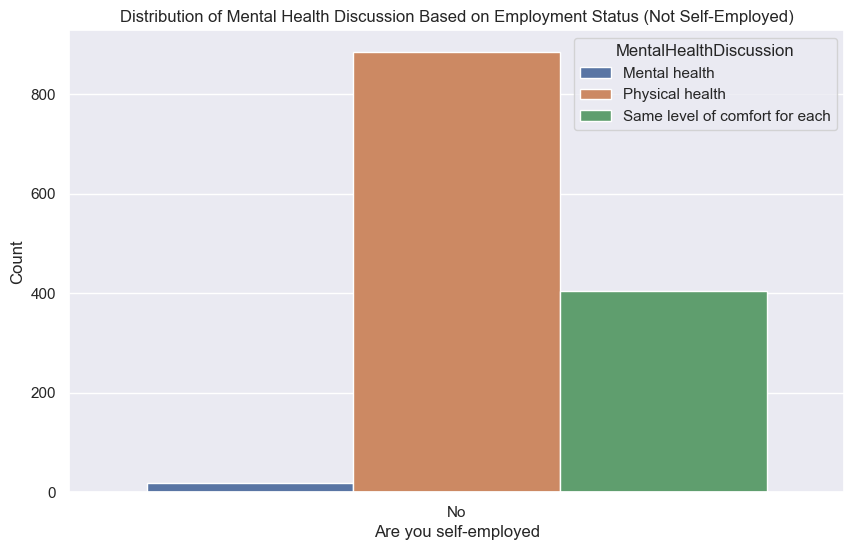

In [86]:
employment_status_question_id = 5  # "Are you self-employed?"
mental_health_discussion_question_id = 57  # "Would you feel more comfortable talking to your coworkers about your physical health or your mental health?"

# Query to retrieve data for the analysis (excluding rows where self-employed is -1)
query = f"""
    SELECT EmploymentStatus.AnswerText as EmploymentStatus, MentalHealthDiscussion.AnswerText as MentalHealthDiscussion, COUNT(*) as Count
    FROM Answer as EmploymentStatus
    JOIN Answer as MentalHealthDiscussion ON EmploymentStatus.UserID = MentalHealthDiscussion.UserID
    WHERE EmploymentStatus.QuestionID = {employment_status_question_id} AND MentalHealthDiscussion.QuestionID = {mental_health_discussion_question_id}
        AND EmploymentStatus.AnswerText = '0'  -- Select only where not self-employed
        AND MentalHealthDiscussion.AnswerText <> '-1'  -- Exclude rows with -1 in mental health discussion
    GROUP BY EmploymentStatus.AnswerText, MentalHealthDiscussion.AnswerText;
"""

self_employed_vs_organization_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(10, 6))
sns.barplot(x='EmploymentStatus', y='Count', hue='MentalHealthDiscussion', data=self_employed_vs_organization_data)
plt.xticks(ticks=[0], labels=['No'])
plt.title('Distribution of Mental Health Discussion Based on Employment Status (Not Self-Employed)')
plt.xlabel('Are you self-employed')
plt.ylabel('Count')
plt.show()

### It appears that employees are more inclined to discuss physical health rather than mental health with their coworkers.

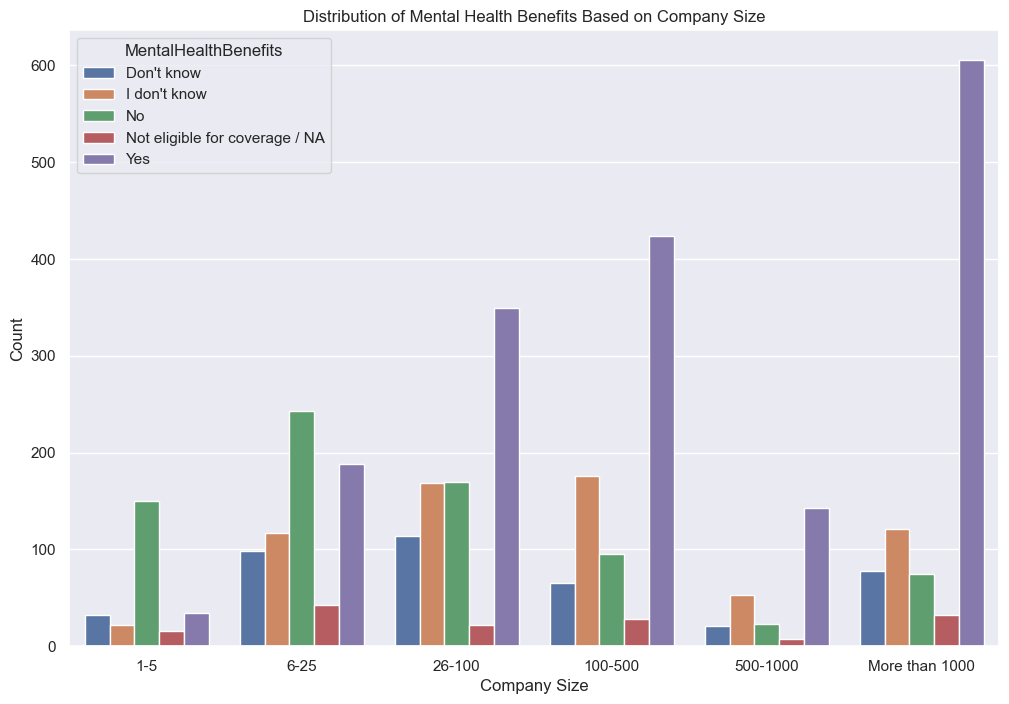

In [92]:
company_size_question_id = 8  # "How many employees does your company or organization have?"
mental_health_benefits_question_id = 10  # "Does your employer provide mental health benefits as part of healthcare coverage?"

# Query to retrieve data for the analysis, excluding -1 values for question 10
query = f"""
    SELECT CompanySize.AnswerText as CompanySize, MentalHealthBenefits.AnswerText as MentalHealthBenefits, COUNT(*) as Count
    FROM Answer as CompanySize
    JOIN Answer as MentalHealthBenefits ON CompanySize.UserID = MentalHealthBenefits.UserID
    WHERE CompanySize.QuestionID = {company_size_question_id} 
        AND MentalHealthBenefits.QuestionID = {mental_health_benefits_question_id}
        AND MentalHealthBenefits.AnswerText != '-1'
    GROUP BY CompanySize.AnswerText, MentalHealthBenefits.AnswerText;
"""

company_size_vs_mental_health_benefits_data = pd.read_sql_query(query, conn)
order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]  # Update with your actual values

plt.figure(figsize=(12, 8))
sns.barplot(x='CompanySize', y='Count', hue='MentalHealthBenefits', data=company_size_vs_mental_health_benefits_data, order=order)
plt.title('Distribution of Mental Health Benefits Based on Company Size')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.show()

### Larger companies appear to offer a higher incidence of mental health benefits as part of their healthcare coverage compared to smaller companies.

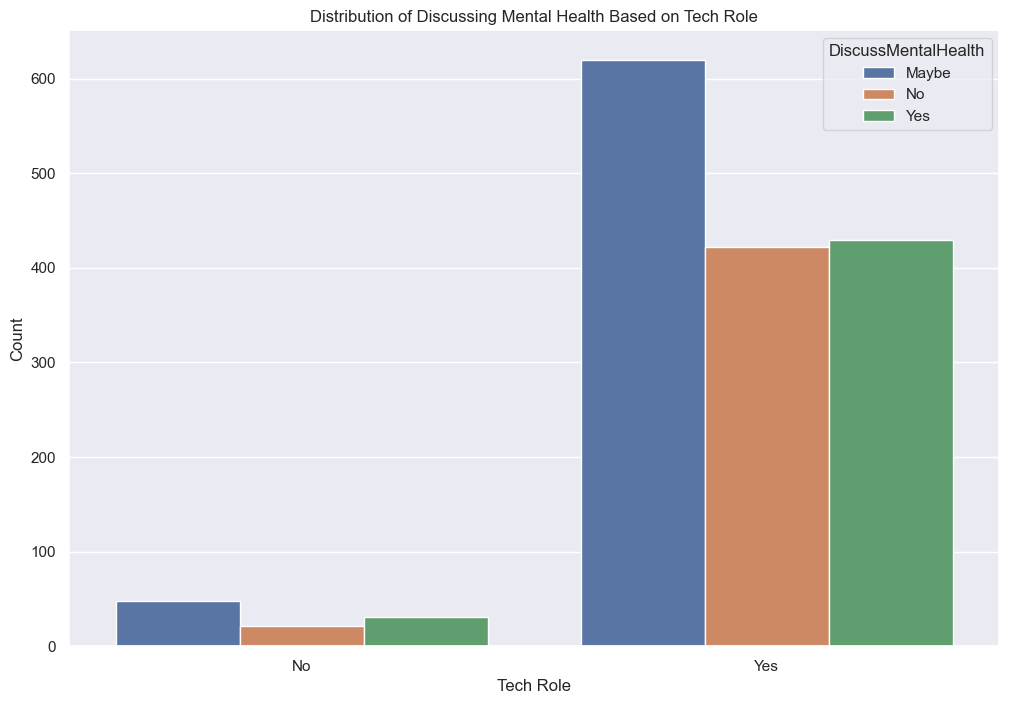

In [93]:
tech_role_question_id = 13  # "Is your primary role within your company related to tech/IT?"
discuss_mental_health_question_id = 18  # "Would you feel comfortable discussing a mental health issue with your coworkers?"

# Query to retrieve data for the analysis (excluding -1 values)
query = f"""
    SELECT TechRole.AnswerText as TechRole, DiscussMentalHealth.AnswerText as DiscussMentalHealth, COUNT(*) as Count
    FROM Answer as TechRole
    JOIN Answer as DiscussMentalHealth ON TechRole.UserID = DiscussMentalHealth.UserID
    WHERE TechRole.QuestionID = {tech_role_question_id} AND TechRole.AnswerText != '-1'
        AND DiscussMentalHealth.QuestionID = {discuss_mental_health_question_id} AND DiscussMentalHealth.AnswerText != '-1'
    GROUP BY TechRole.AnswerText, DiscussMentalHealth.AnswerText;
"""

tech_role_vs_discuss_mental_health_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(12, 8))
sns.barplot(x='TechRole', y='Count', hue='DiscussMentalHealth', data=tech_role_vs_discuss_mental_health_data)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.title('Distribution of Discussing Mental Health Based on Tech Role')
plt.xlabel('Tech Role')
plt.ylabel('Count')
plt.show()

### It appears that individuals in tech/IT roles are more at ease discussing mental health issues with their coworkers.

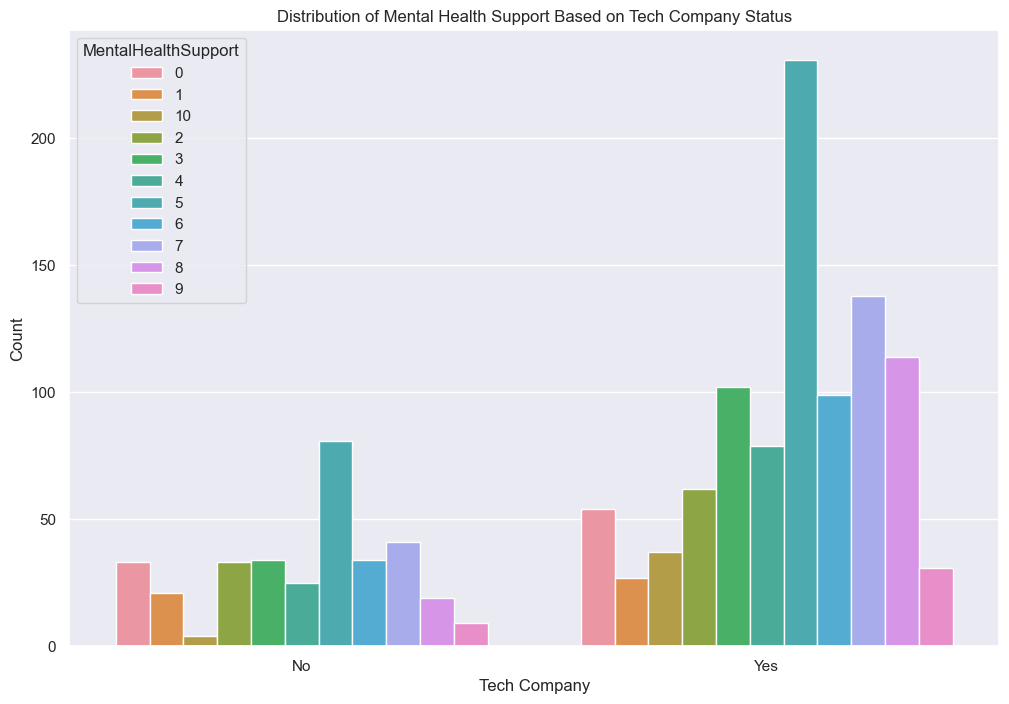

In [94]:
tech_company_question_id = 9  # "Is your employer primarily a tech company/organization?"
mental_health_support_question_id = 65  # "Overall, how much importance does your employer place on mental health?"

# Query to retrieve data for the analysis (excluding -1 values)
query = f"""
    SELECT TechCompany.AnswerText as TechCompany, MentalHealthSupport.AnswerText as MentalHealthSupport, COUNT(*) as Count
    FROM Answer as TechCompany
    JOIN Answer as MentalHealthSupport ON TechCompany.UserID = MentalHealthSupport.UserID
    WHERE TechCompany.QuestionID = {tech_company_question_id} AND TechCompany.AnswerText != '-1'
        AND MentalHealthSupport.QuestionID = {mental_health_support_question_id} AND MentalHealthSupport.AnswerText != '-1'
    GROUP BY TechCompany.AnswerText, MentalHealthSupport.AnswerText;
"""

tech_company_vs_mental_health_support_data = pd.read_sql_query(query, conn)

plt.figure(figsize=(12, 8))
sns.barplot(x='TechCompany', y='Count', hue='MentalHealthSupport', data=tech_company_vs_mental_health_support_data)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.title('Distribution of Mental Health Support Based on Tech Company Status')
plt.xlabel('Tech Company')
plt.ylabel('Count')
plt.show()

### It seems that tech companies/organizations prioritize mental health to a greater extent.

<a id="12"></a> 
# 5. Summary and Suggestions

**Summary:**

The analysis of mental health survey data reveals several key trends and insights:

1. **Survey Participation Trends:**
   - The number of respondents increased from 2014 to 2016 but declined in subsequent years.
   - Most respondents are in the younger age groups, particularly in their 20s and 30s.

2. **Average Age Shift:**
   - The average age of respondents shifted to the 30s group over the years.
   - There is a general upward trend in the average age of respondents.

3. **Treatment Seeking Behavior:**
   - Individuals in younger age groups (17-27) are less inclined to seek treatment for mental health disorders.
   - The propensity to seek treatment notably increases among individuals aged 28 and older.
   - There is a growing interest in seeking treatment for mental health disorders over the years.

4. **Gender Distribution:**
   - The survey is predominantly composed of male respondents.

5. **Willingness to Discuss Mental Health:**
   - There is a similar willingness among both males and females to discuss mental health.
   - Employees are more inclined to discuss physical health rather than mental health with their coworkers.

6. **Geographical Insights:**
   - A majority of respondents are based in the United States.
   - Michigan, New York, and Illinois stand out as frontrunners in providing mental health support.

7. **Correlations:**
   - There is a strong link between past mental health disorders and current conditions.
   - Family mental health history shows a strong correlation with past/present disorders.
   - Seeking treatment correlates strongly with past and present mental health issues.

8. **Work Environment Impact:**
   - Individuals who work remotely experience a lesser impact on their work due to mental health conditions.

9. **Company Size and Mental Health Benefits:**
   - Larger companies offer a higher incidence of mental health benefits as part of healthcare coverage compared to smaller companies.

10. **Tech/IT Roles and Mental Health Discussions:**
    - Individuals in tech/IT roles are more at ease discussing mental health issues with their coworkers.

**Suggestions:**

1. **Targeted Outreach:**
   - Develop targeted outreach efforts to encourage participation from a diverse age group to ensure a more representative sample.

2. **Age-Specific Interventions:**
   - Tailor mental health interventions to address the unique needs of different age groups, particularly focusing on younger individuals.

3. **Awareness Campaigns:**
   - Implement awareness campaigns to destigmatize mental health discussions, especially among male respondents.

4. **Geographical Support:**
   - Consider implementing mental health support initiatives in states with lower average support levels, aiming to bridge the gap.

5. **Remote Work Support:**
   - Continue supporting remote work, acknowledging its positive impact on mental health conditions.

6. **Company Size Considerations:**
   - Provide insights to smaller companies on the benefits of including mental health coverage in their healthcare plans.

7. **Tech Industry Initiatives:**
   - Encourage other industries to adopt practices from the tech industry that prioritize mental health support.

8. **Holistic Health Approach:**
   - Advocate for a holistic approach to health discussions in workplaces, emphasizing both physical and mental well-being.